In [1]:
from torch.utils.data import  Dataset
from torchvision import transforms as T
from PIL import Image
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
import hashlib
import cv2
import random

### Loading dataset

In [2]:
class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.paths = sorted(glob(f"{root}/*/*"))
        self.transform = transform
        self.class_names = sorted(os.listdir(root))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.class_names)}

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        img = Image.open(path).convert("RGB")
        label_name = os.path.basename(os.path.dirname(path))
        label = self.class_to_idx[label_name]
        if self.transform:
            img = self.transform(img)
        return img, label

root = os.path.join("Lung X-Ray Image", "Lung X-Ray Image")

transform = None

dataset = CustomDataset(root, transform)

# Data cleaning

### Checking duplicates

If a duplicated file is detected, it will be deleted

In [3]:
def file_hash(path, block_size=65536):
    hash_md5 = hashlib.md5()
    with open(path, "rb") as f:
        for block in iter(lambda: f.read(block_size), b""):
            hash_md5.update(block)
    return hash_md5.hexdigest()

all_files = sorted(glob(os.path.join(root, "*", "*")))

hash_dict = {}
duplicates_removed = []

for file in all_files:
    h = file_hash(file)
    if h not in hash_dict:
        hash_dict[h] = file  
    else:
        duplicates_removed.append(file)
        os.remove(file)     

print(f"Deleted duplicates: {len(duplicates_removed)}\n")

if duplicates_removed:
    print("Deleted duplicate files:")
    for f in duplicates_removed:
        print("  -", f)
else:
    print("No duplicate files found.")


Deleted duplicates: 0

No duplicate files found.


# Descriptive analysis

## Dataset dimensions

### Dataset size

In [4]:
print(f"Total image number : {len(dataset)}")
print(f"Number of classes : {len(dataset.class_names)}")
print(f"Classes : {dataset.class_names}")

Total image number : 3319
Number of classes : 3
Classes : ['Lung_Opacity', 'Normal', 'Viral Pneumonia']


### Pictures dimensions

In [5]:
widths = []
heights = []
aspect_ratios = []

sample_size = min(500, len(dataset))
indices = np.random.choice(len(dataset), sample_size, replace=False)

for idx in indices:
    img, _ = dataset[idx]
    width, height = img.size
    widths.append(width)
    heights.append(height)
    aspect_ratios.append(width / height)

print(f"Dimensions ({sample_size} sample)")
print(f"width  : min={min(widths):4d}, max={max(widths):4d}, average={np.mean(widths):6.1f}, median={np.median(widths):6.1f}")
print(f"length  : min={min(heights):4d}, max={max(heights):4d}, average={np.mean(heights):6.1f}, median={np.median(heights):6.1f}")
print(f"Ratio L/H: min={min(aspect_ratios):.3f}, max={max(aspect_ratios):.3f}, average={np.mean(aspect_ratios):.3f}")

Dimensions (500 sample)
width  : min= 299, max= 299, average= 299.0, median= 299.0
length  : min= 299, max= 299, average= 299.0, median= 299.0
Ratio L/H: min=1.000, max=1.000, average=1.000


## Class balance

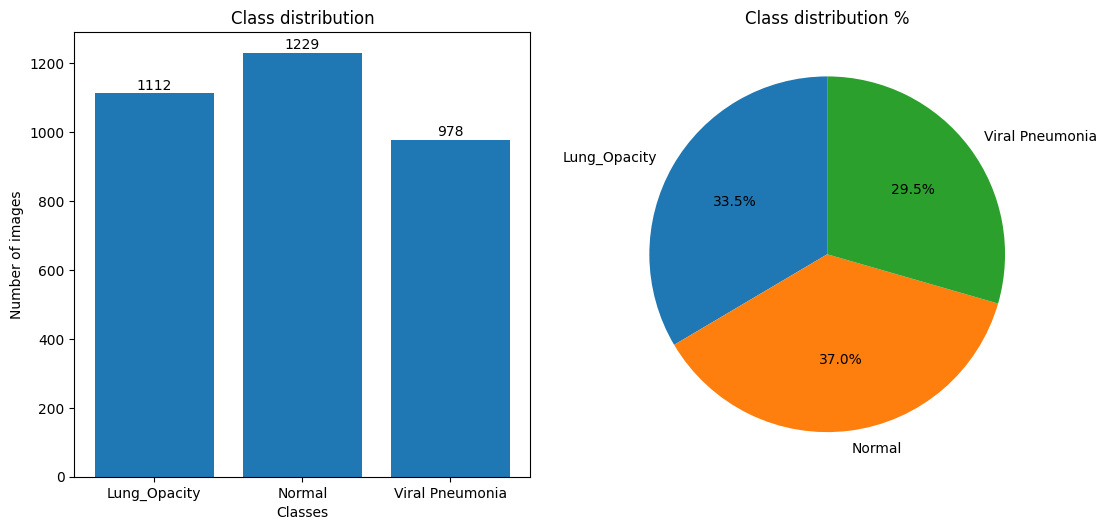

In [6]:
# Calculating class distribution
class_counts = Counter()
for path in dataset.paths:
    label_name = os.path.basename(os.path.dirname(path))
    class_counts[label_name] += 1

fig = plt.figure(figsize=(16, 10))

# Visualisation
ax1 = plt.subplot(2, 3, 1)
classes = dataset.class_names
counts = [class_counts[c] for c in classes]

ax1.bar(classes, counts)
ax1.set_xlabel("Classes")
ax1.set_ylabel("Number of images")
ax1.set_title("Class distribution")


for i, val in enumerate(counts):
    ax1.text(i, val + max(counts)*0.01, str(val), ha='center')


ax2 = plt.subplot(2, 3, 2)
ax2.pie(counts, labels=classes, autopct='%1.1f%%', startangle=90)
ax2.set_title("Class distribution %")

plt.tight_layout()
plt.show()

=> Good balance so no correction needed

## Example pictures

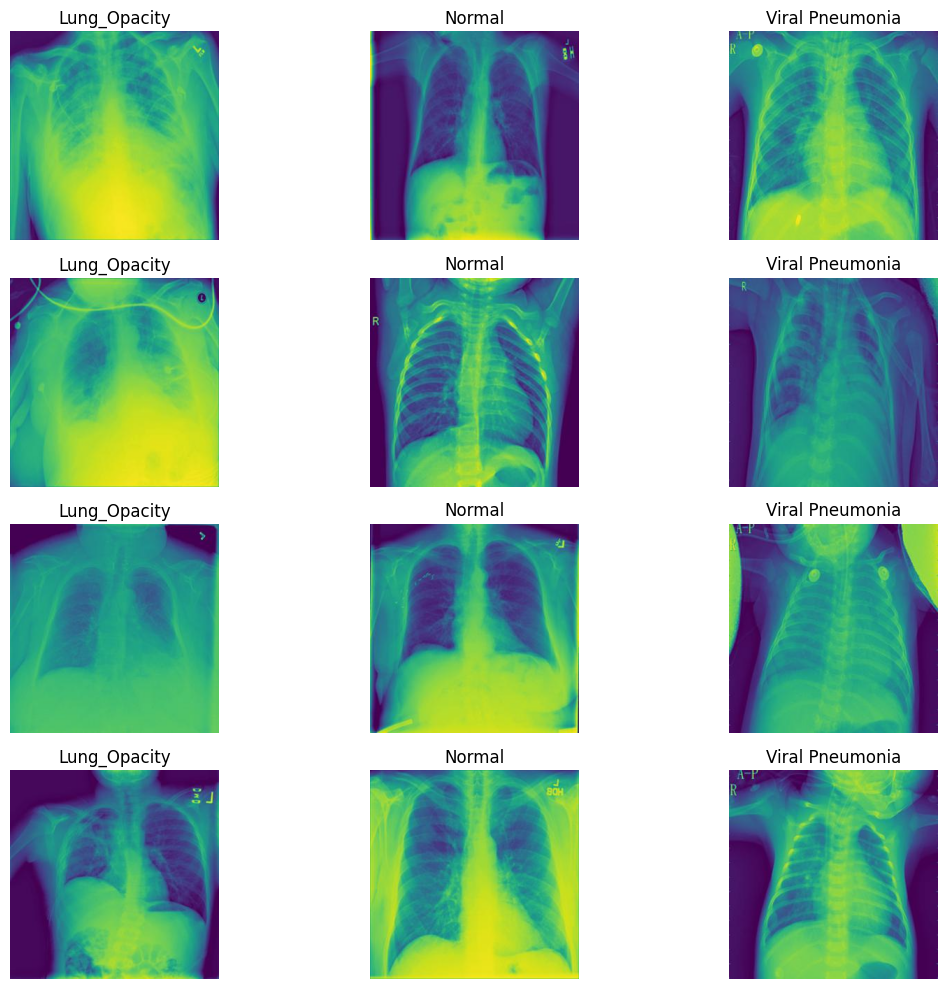

In [7]:
plt.figure(figsize=(12, 10))

num_examples = 4
num_classes = len(dataset.class_names)

for c, cls in enumerate(dataset.class_names):
    img_paths = glob(os.path.join(root, cls, "*"))[:num_examples]

    for i, img_path in enumerate(img_paths):
        img = Image.open(img_path)
        plt.subplot(num_examples, num_classes, i * num_classes + c + 1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis("off")

plt.tight_layout()
plt.show()

# Data augmentation visualisation

In this part, we will apply some data augmentation techniques and visualize them.

It will help us choose the most relevant ones.

### Rotations

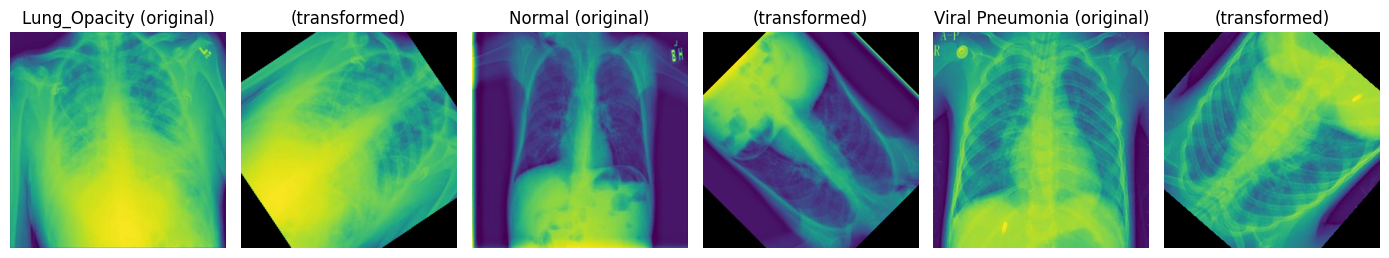

In [8]:
augment = T.Compose([
    T.RandomRotation(360)
])

num_examples = 1
classes = dataset.class_names

plt.figure(figsize=(14, 12))

for c, cls in enumerate(classes):
    img_paths = glob(os.path.join(root, cls, "*"))[:num_examples]

    for i, img_path in enumerate(img_paths):
        img = Image.open(img_path).convert("RGB")
        transformed = augment(img)

        idx_original = i * len(classes) * 2 + (c * 2) + 1
        plt.subplot(num_examples, len(classes)*2, idx_original)
        plt.imshow(img)
        plt.title(f"{cls} (original)")
        plt.axis("off")

        idx_aug = idx_original + 1
        plt.subplot(num_examples, len(classes)*2, idx_aug)
        plt.imshow(transformed)
        plt.title("(transformed)")
        plt.axis("off")

plt.tight_layout()
plt.show()


### Translation

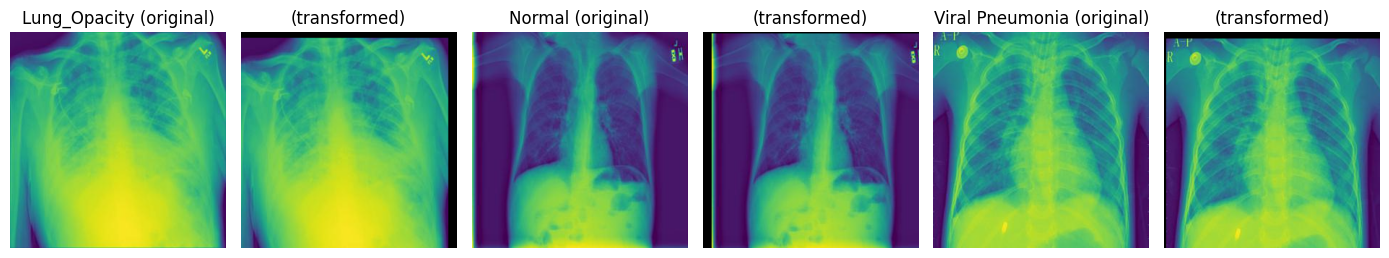

In [9]:
augment = T.Compose([
    T.RandomAffine(degrees=0, translate=[0.05, 0.05])
])

num_examples = 1
classes = dataset.class_names

plt.figure(figsize=(14, 12))

for c, cls in enumerate(classes):
    img_paths = glob(os.path.join(root, cls, "*"))[:num_examples]

    for i, img_path in enumerate(img_paths):
        img = Image.open(img_path).convert("RGB")
        transformed = augment(img)

        idx_original = i * len(classes) * 2 + (c * 2) + 1
        plt.subplot(num_examples, len(classes)*2, idx_original)
        plt.imshow(img)
        plt.title(f"{cls} (original)")
        plt.axis("off")

        idx_aug = idx_original + 1
        plt.subplot(num_examples, len(classes)*2, idx_aug)
        plt.imshow(transformed)
        plt.title("(transformed)")
        plt.axis("off")

plt.tight_layout()
plt.show()


### Scale

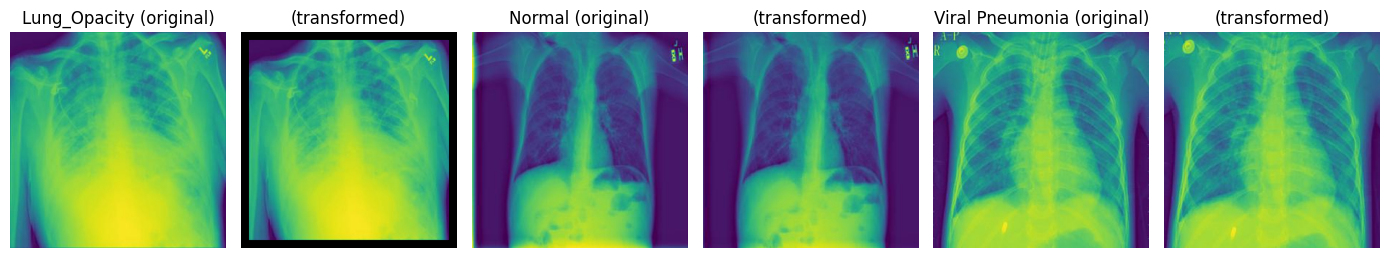

In [10]:
augment = T.Compose([
    T.RandomAffine(degrees=0, scale=[0.8,1.2])
])

num_examples = 1
classes = dataset.class_names

plt.figure(figsize=(14, 12))

for c, cls in enumerate(classes):
    img_paths = glob(os.path.join(root, cls, "*"))[:num_examples]

    for i, img_path in enumerate(img_paths):
        img = Image.open(img_path).convert("RGB")
        transformed = augment(img)

        idx_original = i * len(classes) * 2 + (c * 2) + 1
        plt.subplot(num_examples, len(classes)*2, idx_original)
        plt.imshow(img)
        plt.title(f"{cls} (original)")
        plt.axis("off")

        idx_aug = idx_original + 1
        plt.subplot(num_examples, len(classes)*2, idx_aug)
        plt.imshow(transformed)
        plt.title("(transformed)")
        plt.axis("off")

plt.tight_layout()
plt.show()


### Brightness

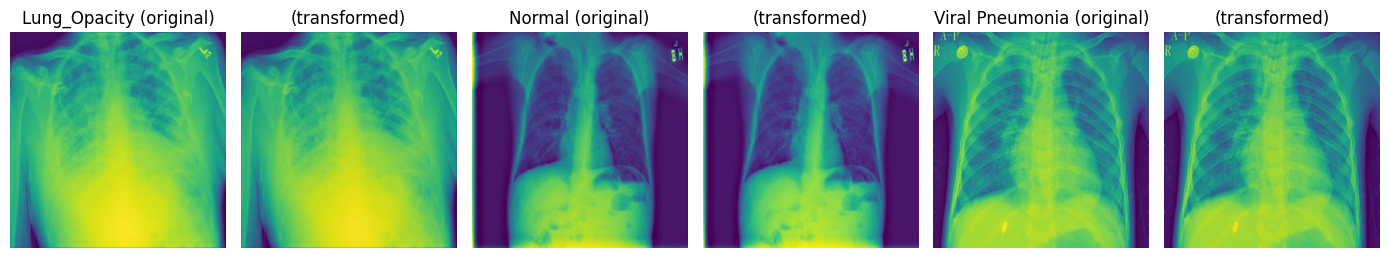

In [11]:
augment = T.Compose([
    T.ColorJitter(brightness=[0.8,1.2])
])

num_examples = 1
classes = dataset.class_names

plt.figure(figsize=(14, 12))

for c, cls in enumerate(classes):
    img_paths = glob(os.path.join(root, cls, "*"))[:num_examples]

    for i, img_path in enumerate(img_paths):
        img = Image.open(img_path).convert("RGB")
        transformed = augment(img)

        idx_original = i * len(classes) * 2 + (c * 2) + 1
        plt.subplot(num_examples, len(classes)*2, idx_original)
        plt.imshow(img)
        plt.title(f"{cls} (original)")
        plt.axis("off")

        idx_aug = idx_original + 1
        plt.subplot(num_examples, len(classes)*2, idx_aug)
        plt.imshow(transformed)
        plt.title("(transformed)")
        plt.axis("off")

plt.tight_layout()
plt.show()


### Contrast

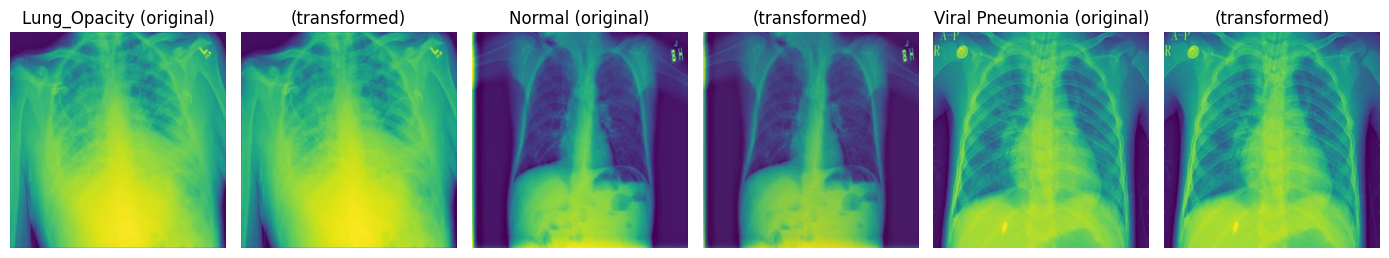

In [114]:
augment = T.Compose([
    T.ColorJitter(contrast=[0.8, 1.2])
])

num_examples = 1
classes = dataset.class_names

plt.figure(figsize=(14, 12))

for c, cls in enumerate(classes):
    img_paths = glob(os.path.join(root, cls, "*"))[:num_examples]

    for i, img_path in enumerate(img_paths):
        img = Image.open(img_path).convert("RGB")
        transformed = augment(img)

        idx_original = i * len(classes) * 2 + (c * 2) + 1
        plt.subplot(num_examples, len(classes)*2, idx_original)
        plt.imshow(img)
        plt.title(f"{cls} (original)")
        plt.axis("off")

        idx_aug = idx_original + 1
        plt.subplot(num_examples, len(classes)*2, idx_aug)
        plt.imshow(transformed)
        plt.title("(transformed)")
        plt.axis("off")

plt.tight_layout()
plt.show()


### Saturation

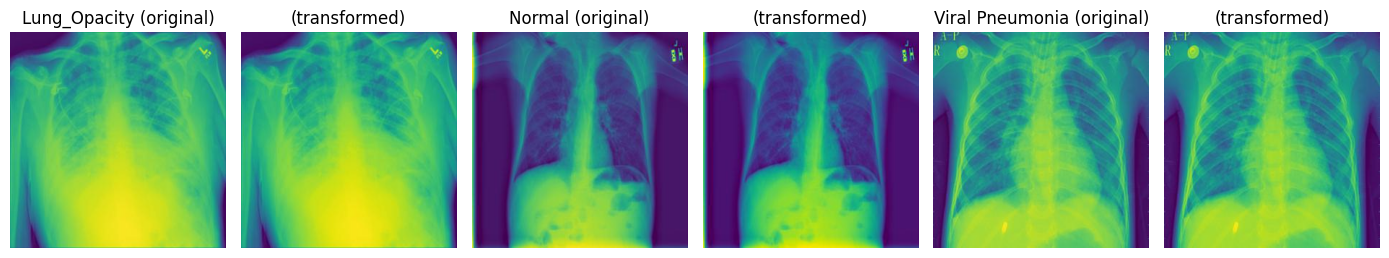

In [5]:
augment = T.Compose([
    T.ColorJitter(saturation=[0.8, 1.2])
])

num_examples = 1
classes = dataset.class_names

plt.figure(figsize=(14, 12))

for c, cls in enumerate(classes):
    img_paths = glob(os.path.join(root, cls, "*"))[:num_examples]

    for i, img_path in enumerate(img_paths):
        img = Image.open(img_path).convert("RGB")
        transformed = augment(img)

        idx_original = i * len(classes) * 2 + (c * 2) + 1
        plt.subplot(num_examples, len(classes)*2, idx_original)
        plt.imshow(img)
        plt.title(f"{cls} (original)")
        plt.axis("off")

        idx_aug = idx_original + 1
        plt.subplot(num_examples, len(classes)*2, idx_aug)
        plt.imshow(transformed)
        plt.title("(transformed)")
        plt.axis("off")

plt.tight_layout()
plt.show()

### Grayscale

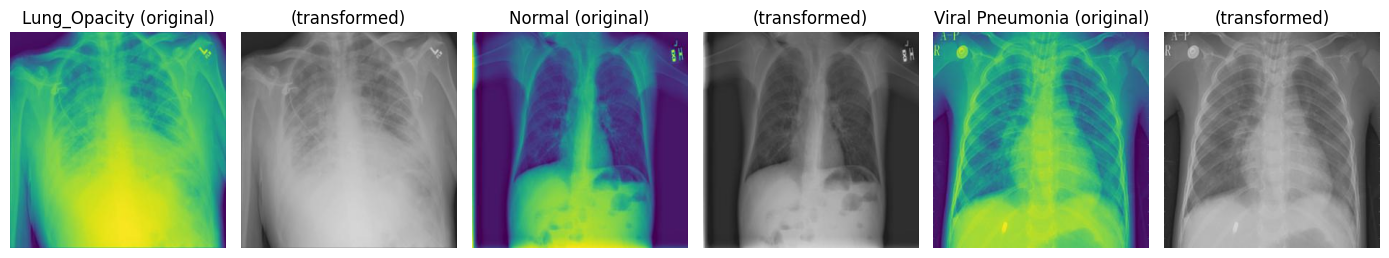

In [ ]:
augment = T.Compose([
    T.Grayscale(num_output_channels=3)
])

num_examples = 1
classes = dataset.class_names

plt.figure(figsize=(14, 12))

for c, cls in enumerate(classes):
    img_paths = glob(os.path.join(root, cls, "*"))[:num_examples]

    for i, img_path in enumerate(img_paths):
        img = Image.open(img_path).convert("RGB")
        transformed = augment(img)

        idx_original = i * len(classes) * 2 + (c * 2) + 1
        plt.subplot(num_examples, len(classes)*2, idx_original)
        plt.imshow(img)
        plt.title(f"{cls} (original)")
        plt.axis("off")

        idx_aug = idx_original + 1
        plt.subplot(num_examples, len(classes)*2, idx_aug)
        plt.imshow(transformed)
        plt.title("(transformed)")
        plt.axis("off")

plt.tight_layout()
plt.show()

### CLAHE

CLAHE (Contrast Limited Adaptive Histogram Equalization) is an image enhancement technique designed to improve local contrast while avoiding the noise amplification that standard histogram equalization often causes.

Instead of applying a single global histogram equalization to the entire image, CLAHE divides the image into small regions (called tiles) and enhances each one independently. To keep the contrast under control, it introduces a clip limit that prevents any histogram bin from becoming too dominant — this is what helps reduce noise and over-amplified artifacts.

CLAHE is widely used in medical imaging (like X-ray or CT scans), low-light photos, and any domain where subtle details matter. It can reveal structures that would otherwise remain too dark or too bright, making patterns more visible for both human interpretation and machine-learning models.

In [12]:
class CLAHE:
    """
    Transform compatible PIL.Image -> PIL.Image that applies CLAHE on the luminance channel.
    Params:
      clip_limit: float (OpenCV-style, e.g. 2.0)
      tile_grid_size: tuple (width_tiles, height_tiles), e.g. (8,8)
      p: probability to apply (0..1)
    """
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8), p=1.0):
        self.clip_limit = clip_limit
        self.tile_grid_size = tuple(tile_grid_size)
        self.p = float(p)
        self._clahe = cv2.createCLAHE(clipLimit=float(self.clip_limit), tileGridSize=self.tile_grid_size)

    def __call__(self, img):       
        if random.random() > self.p:
            return img

        arr = np.array(img)

        bgr = cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)
        lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        l2 = self._clahe.apply(l)
        lab2 = cv2.merge((l2, a, b))
        bgr2 = cv2.cvtColor(lab2, cv2.COLOR_LAB2BGR)
        rgb2 = cv2.cvtColor(bgr2, cv2.COLOR_BGR2RGB)
        return Image.fromarray(rgb2)


    def __repr__(self):
        return (f"CLAHETransform(clip_limit={self.clip_limit}, tile_grid_size={self.tile_grid_size}, p={self.p})")

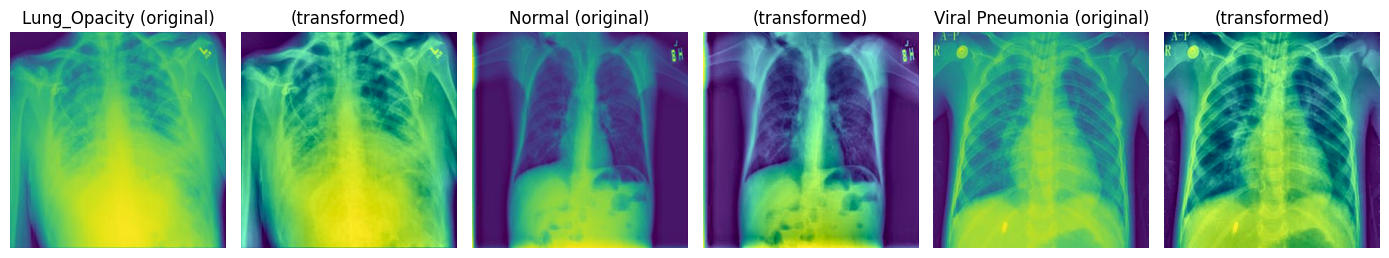

In [13]:
augment = T.Compose([
    CLAHE(2.0,(8,8),p=1.0),
])

num_examples = 1
classes = dataset.class_names

plt.figure(figsize=(14, 12))

for c, cls in enumerate(classes):
    img_paths = glob(os.path.join(root, cls, "*"))[:num_examples]

    for i, img_path in enumerate(img_paths):
        img = Image.open(img_path).convert("RGB")
        transformed = augment(img)

        idx_original = i * len(classes) * 2 + (c * 2) + 1
        plt.subplot(num_examples, len(classes)*2, idx_original)
        plt.imshow(img)
        plt.title(f"{cls} (original)")
        plt.axis("off")

        idx_aug = idx_original + 1
        plt.subplot(num_examples, len(classes)*2, idx_aug)
        plt.imshow(transformed)
        plt.title("(transformed)")
        plt.axis("off")

plt.tight_layout()
plt.show()